#### Segmentation models with pretrained backbones

In [1]:
import os
import numpy as np
from PIL import Image
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torchvision
import segmentation_models_pytorch as smp
import albumentations as A  
from albumentations.pytorch import ToTensorV2
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
def seed_everything(seed):
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True
    
seed_everything(42)

In [3]:
class SegmentationDataset(Dataset):
    def __init__(self, input_dir, output_dir, is_train, transform=None):
        self.input_dir  = input_dir
        self.output_dir = output_dir
        self.transform  = transform
        if is_train == True:
            # x = round(len(os.listdir(input_dir)) * .8)
            self.images = os.listdir(input_dir)
        else:
            # x = round(len(os.listdir(input_dir)) * .8)
            self.images = os.listdir(input_dir)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        img_path    = os.path.join(self.input_dir, self.images[index])
        mask_path   = os.path.join(self.output_dir, self.images[index])
        img         = np.array(Image.open(img_path).convert("RGB"), dtype=np.float32) / 255
        mask        = np.array(Image.open(mask_path).convert("L"), dtype=np.float32)   / 255
        
        if self.transform is not None:
            augmentations = self.transform(image=img, mask=mask)
            img   = augmentations["image"]
            mask  = augmentations["mask"]
        
        return img, mask

In [4]:
TRAIN_INP_DIR = '/data1/vinod/mitosis/data/processed/train/input'
TRAIN_OUT_DIR = '/data1/vinod/mitosis/data/processed/train/output'
VAL_INP_DIR = '/data1/vinod/mitosis/data/processed/val/input'
VAL_OUT_DIR = '/data1/vinod/mitosis/data/processed/val/output'
DEVICE        = "cuda" if torch.cuda.is_available() else "cpu"

In [29]:
LEARNING_RATE = 3e-4
BATCH_SIZE    = 8
NUM_EPOCHS    = 3
IMAGE_HEIGHT  = 512  
IMAGE_WIDTH   = 512  

In [30]:
train_transform = A.Compose(
    [
        A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
        A.ColorJitter(p=0.2),
        A.HorizontalFlip(p=0.5),
        ToTensorV2(),
    ],
)

val_transform = A.Compose(
    [
        A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
        ToTensorV2(),
    ],
)

In [31]:
def get_loaders( inp_dir_t, mask_dir_t, inp_dir_v, mask_dir_v, batch_size,train_transform, val_tranform ):
    
    train_ds     = SegmentationDataset( input_dir=inp_dir_t, output_dir=mask_dir_t,
                            is_train=True, transform=train_transform)

    train_loader = DataLoader( train_ds, batch_size=batch_size, shuffle=True )

    val_ds       = SegmentationDataset( input_dir=inp_dir_v, output_dir=mask_dir_v,
                            is_train=False, transform=val_transform)

    val_loader   = DataLoader( val_ds, batch_size=batch_size, shuffle=True  )

    return train_loader, val_loader

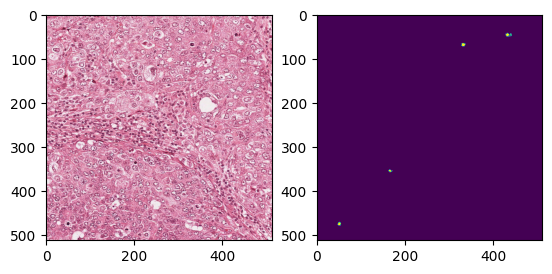

In [32]:
train_loader, val_loader = get_loaders( TRAIN_INP_DIR, TRAIN_OUT_DIR, VAL_INP_DIR, VAL_OUT_DIR, BATCH_SIZE,  train_transform, val_transform)
inputs, masks = next(iter(train_loader))

_, ax = plt.subplots(1,2)
ax[0].imshow(inputs[0].permute(1,2,0))
ax[1].imshow(masks[0])

In [40]:
def check_accuracy(loader, model, device="cuda"):
    num_correct = 0
    num_pixels  = 0
    dice_score  = 0
    iou_score = 0
    model.eval()

    with torch.no_grad():
        for img, mask in tqdm(loader):
            img   = img.to(device)
            mask  = mask.to(device).unsqueeze(1)
            preds = torch.sigmoid(model(img))
            preds = (preds > 0.5).float()
            num_correct += (preds == mask).sum()
            num_pixels += torch.numel(preds)
            dice_score += (2 * (preds * mask).sum()) / (
                (preds + mask).sum() + 1e-7
            )
            intersection = (preds * mask).sum()
            union = (preds + mask).sum()
            iou_score += (intersection + 1e-7) / (union + 1e-7)


    print(f"Got {num_correct}/{num_pixels} with pixel accuracy {num_correct/num_pixels*100:.2f}", flush=True)
    print(f"Dice score: {dice_score/len(loader)*100:.2f}", flush=True)
    print(f"IoU score: {iou_score/len(loader)*100:.2f}", flush=True)

    model.train()

In [41]:
model = smp.UnetPlusPlus(encoder_name='resnet34', encoder_depth=2,decoder_channels=(128, 64), in_channels=3, classes=1, activation=None).to(DEVICE)
loss_fn   = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [42]:
def train_fn(loader, model, optimizer, loss_fn):
    loop = tqdm(loader)

    for batch_idx, (image, mask) in enumerate(loop):
        image   = image.to(device=DEVICE)
        mask    = mask.float().unsqueeze(1).to(device=DEVICE)

        # forward
        predictions = model(image)
        loss = loss_fn(predictions, mask)

        # backward
        model.zero_grad()
        loss.backward()
        optimizer.step()

        # update tqdm loop
        loop.set_postfix(loss=loss.item())

In [43]:
check_accuracy(val_loader, model, device=DEVICE)

100%|██████████| 3/3 [00:02<00:00,  1.03it/s]

Got 222481/4980736 with pixel accuracy 4.47
Dice score: 0.18
IoU score: 0.09


In [44]:
for epoch in range(NUM_EPOCHS):

    print('########################## epoch: '+str(epoch))
    train_fn(train_loader, model, optimizer, loss_fn)
    
    # check accuracy
    check_accuracy(val_loader, model, device=DEVICE)

########################## epoch: 0


100%|██████████| 3/3 [00:02<00:00,  1.02it/s]

Got 4183003/4980736 with pixel accuracy 83.98
Dice score: 0.11
IoU score: 0.06


########################## epoch: 1


100%|██████████| 3/3 [00:02<00:00,  1.02it/s]

Got 4805583/4980736 with pixel accuracy 96.48
Dice score: 0.01
IoU score: 0.00


########################## epoch: 2


100%|██████████| 3/3 [00:02<00:00,  1.02it/s]

Got 4963338/4980736 with pixel accuracy 99.65
Dice score: 0.00
IoU score: 0.00


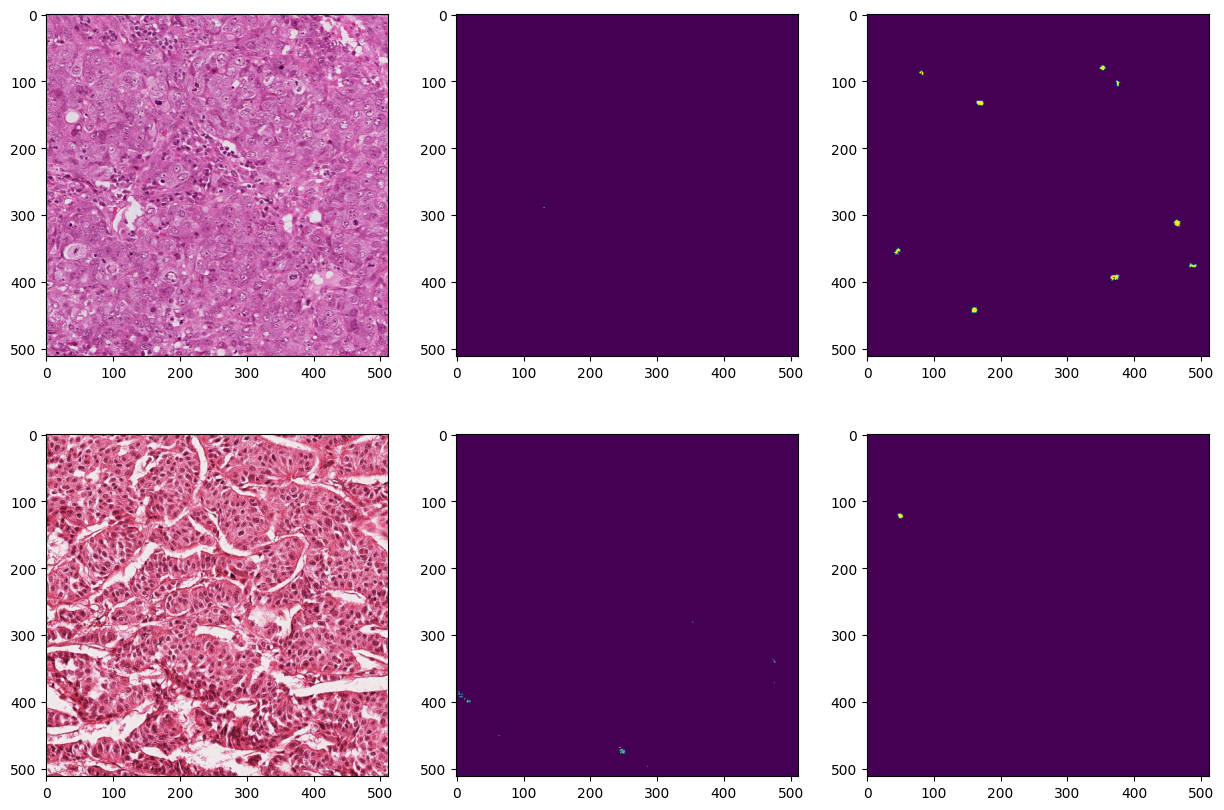

In [45]:
inputs, masks = next(iter(val_loader))
output        = ((torch.sigmoid(model(inputs.to('cuda')))) >0.5).float()
_, ax = plt.subplots(2,3, figsize=(15,10))
for k in range(2):
    ax[k][0].imshow(inputs[k].permute(1,2,0))
    ax[k][1].imshow(output[k][0].cpu())
    ax[k][2].imshow(masks[k])